In [12]:
#basics
import os
from math import sqrt
import pandas
import numpy as np
import random
import pickle



#torch stuff
import torch
from torch.nn import functional as F
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from torch_geometric.nn.models import AttentiveFP
from torch_geometric.loader import DataLoader

import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#set random seeds
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

default_properties = ['LogVP', 'LogP', 'LogOH', 'LogBCF', 'LogHalfLife', 'BP', 'Clint', 'FU', 'LogHL', 'LogKmHL', 'LogKOA', 'LogKOC', 'MP', 'LogMolar']


def train_multi(train_loader, model, optimizer, device, outputs,props_to_train):
    prop_counts = get_scaling_losses(props_to_train)
    idx_to_train = [default_properties.index(prop) for prop in props_to_train]
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        weighted_loss = num_labels = 0
        for i in range(outputs):
            if i not in idx_to_train:
                continue
            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != -1).view(-1)
            num_labels += len(present_label_indices)

            if len(present_label_indices) > 0:
                # Extract only the available label indices
                out_tmp_present = torch.index_select(out_tmp, 0, present_label_indices)
                y_tmp_present = torch.index_select(y_tmp, 0, present_label_indices)

                # Calculate MSE loss only for available labels
                loss_tmp_present = F.mse_loss(out_tmp_present, y_tmp_present)
                if not torch.isnan(loss_tmp_present):
                    weighted_loss += loss_tmp_present * len(present_label_indices)
                    tupp_idx = props_to_train.index(default_properties[i])
                    scale_factor = prop_counts[tupp_idx]
                    weighted_loss = weighted_loss * scale_factor

        weighted_loss = weighted_loss / num_labels
        weighted_loss.backward()

        total_loss += float(weighted_loss) * data.num_graphs
        total_examples += data.num_graphs

        # clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        del data

    return sqrt(total_loss / total_examples)


def validate_multi(val_loader, model, outputs,props_to_train):
    prop_counts = get_scaling_losses(props_to_train)
    idx_to_train = [default_properties.index(prop) for prop in props_to_train]
    total_loss = total_examples = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        weighted_loss = num_labels = 0
        for i in range(outputs):
            if i not in idx_to_train:
                continue

            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != -1).view(-1)
            num_labels += len(present_label_indices)

            if len(present_label_indices) > 0:
                # Extract only the available label indices
                out_tmp_present = torch.index_select(out_tmp, 0, present_label_indices)
                y_tmp_present = torch.index_select(y_tmp, 0, present_label_indices)

                # Calculate MSE loss only for available labels
                loss_tmp_present = F.mse_loss(out_tmp_present, y_tmp_present)
                if not torch.isnan(loss_tmp_present):
                    weighted_loss += loss_tmp_present * len(present_label_indices)
                    tupp_idx = props_to_train.index(default_properties[i])
                    scale_factor = prop_counts[tupp_idx]
                    weighted_loss = weighted_loss * scale_factor


        weighted_loss = weighted_loss / num_labels

        total_loss += float(weighted_loss) * data.num_graphs
        total_examples += data.num_graphs
        del data

    return sqrt(total_loss / total_examples)

def train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs, outputs, verbose=True,props_to_train = default_properties,name='test'):
    train_losses = []
    val_losses = []
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.9,verbose=False)

    min_val_los = 10000000
    for epoch in range(num_epochs):
        model.train()
        train_loss = train_multi(train_loader, model, optimizer, device, outputs,props_to_train)
        train_losses.append(train_loss)

        model.eval()
        val_loss = validate_multi(val_loader, model, outputs,props_to_train)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        if val_loss < min_val_los:
            min_val_los = val_loss
            counter = 0
            torch.save(model.state_dict(), f'{name}.pt')

        else:
            counter += 1
        if counter > 10:
            if verbose:
                print('early stopping')
            break
        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


from scipy.stats import spearmanr,kendalltau

def get_preds_per_task(model,val_loader,outputs,props_to_predict):
    idx_to_pred = [default_properties.index(prop) for prop in props_to_predict]
    model.to(device)
    model.eval()
    preds = tuple([[] for i in range(len(props_to_predict))])
    ys = tuple([[] for i in range(len(props_to_predict))])
    counter = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        
        for i in range(outputs):
            if i not in idx_to_pred:
                continue

            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != -1).view(-1)

            counter += len(present_label_indices)

            # Create arrays with -1 values for indices not in present_label_indices
            preds_tmp = torch.full_like(y_tmp, -1)
            ys_tmp = torch.full_like(y_tmp, -1)

            if len(present_label_indices) > 0:
                # Replace -1 values with predictions and true values where available
                preds_tmp[present_label_indices] = out_tmp[present_label_indices]
                ys_tmp[present_label_indices] = y_tmp[present_label_indices]
            tupp_idx = props_to_predict.index(default_properties[i])
            preds[tupp_idx].extend(preds_tmp.detach().cpu().numpy().tolist())
            ys[tupp_idx].extend(ys_tmp.detach().cpu().numpy().tolist())

    print(counter)
    return preds, ys

def vals_to_df(vals,props_to_predict,scaled=True):
    scaler = pickle.load(open('scaler.pkl', 'rb'))
    df = pd.DataFrame(vals).T
    df.columns = props_to_predict
    if scaled:
        df = df.replace(-1, float('nan'))
        for prop in default_properties:
            if prop not in df.columns:
                df[prop] = float('nan')
        df = df[default_properties]
        df[default_properties] = scaler.inverse_transform(df[default_properties])
        #drop properties with only nans
        df = df.dropna(axis=1, how='all')
    return df

def get_scaling_losses(props):
    train = pd.read_csv('train.csv')
    prop_counts = train[props].count().values.tolist()
    prop_counts = [1 / x for x in prop_counts]
    prop_counts = [x / sum(prop_counts) for x in prop_counts]
    prop_counts = [x / np.mean(prop_counts) for x in prop_counts]
    return prop_counts


Loading previously created graphs
14686 3672
Epoch 1/100: Train Loss: 0.0362, Val Loss: 0.0299
Epoch 2/100: Train Loss: 0.0284, Val Loss: 0.0299
Epoch 3/100: Train Loss: 0.0277, Val Loss: 0.0286
Epoch 4/100: Train Loss: 0.0270, Val Loss: 0.0300
Epoch 5/100: Train Loss: 0.0265, Val Loss: 0.0267
Epoch 6/100: Train Loss: 0.0261, Val Loss: 0.0290
Epoch 7/100: Train Loss: 0.0257, Val Loss: 0.0261
Epoch 8/100: Train Loss: 0.0250, Val Loss: 0.0255
Epoch 9/100: Train Loss: 0.0255, Val Loss: 0.0282
Epoch 10/100: Train Loss: 0.0254, Val Loss: 0.0255
Epoch 11/100: Train Loss: 0.0253, Val Loss: 0.0274
Epoch 12/100: Train Loss: 0.0251, Val Loss: 0.0257
Epoch 13/100: Train Loss: 0.0246, Val Loss: 0.0259
Epoch 14/100: Train Loss: 0.0249, Val Loss: 0.0250
Epoch 15/100: Train Loss: 0.0249, Val Loss: 0.0271
Epoch 16/100: Train Loss: 0.0246, Val Loss: 0.0263
Epoch 17/100: Train Loss: 0.0245, Val Loss: 0.0251
Epoch 18/100: Train Loss: 0.0242, Val Loss: 0.0261
Epoch 19/100: Train Loss: 0.0241, Val Loss: 0.

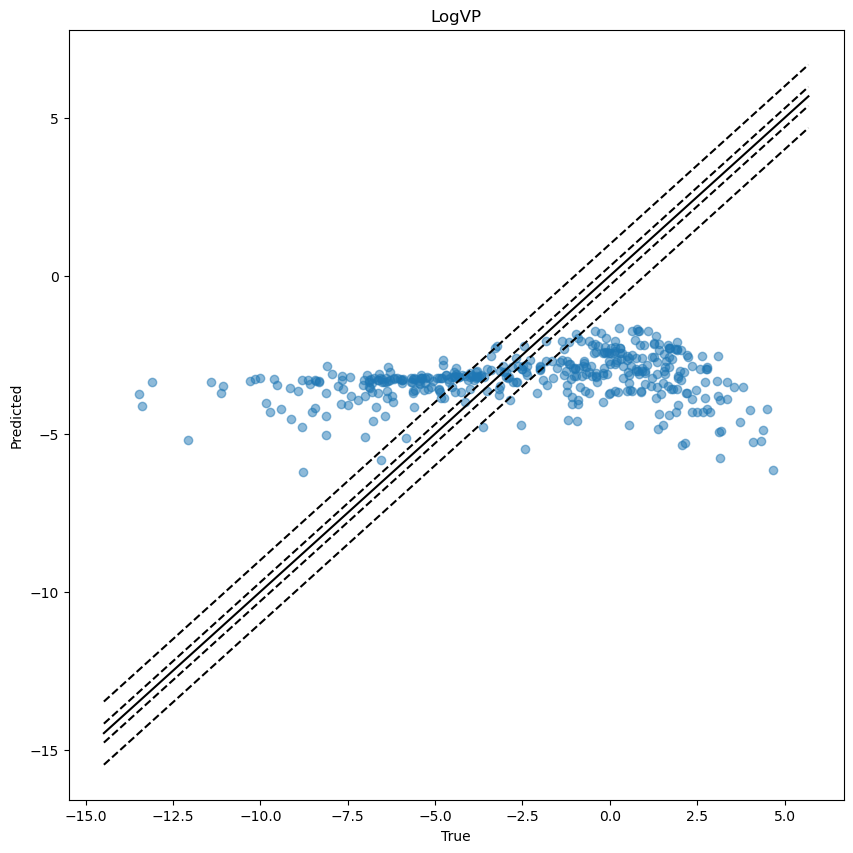

Property: LogP
kendall_tau: 0.5538221327980395
rmse_overall: 1.3132999219974597
mae_overall: 0.9766922769169233
within_03_overall: 0.22537792029317452
within_1_overall: 0.6257443884562529
R2: 0.5027984099477604
Pearson: 0.7428283881647069


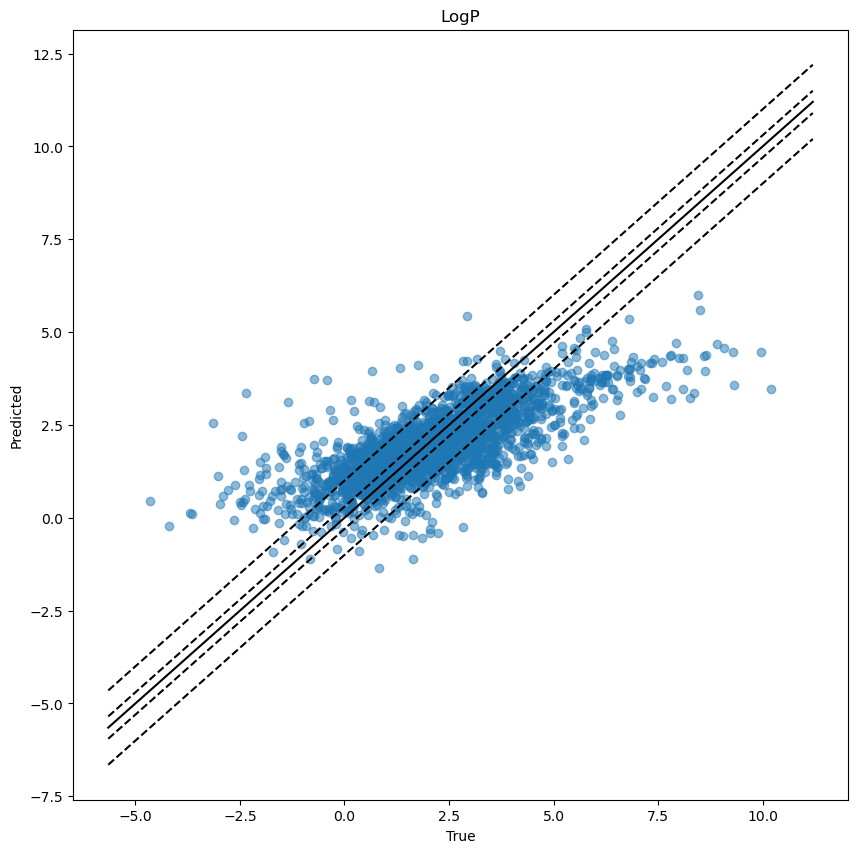

Property: BP
kendall_tau: 0.7265055112557347
rmse_overall: 38.88072793758143
mae_overall: 29.376239027356707
within_03_overall: 0.0024096385542168677
within_1_overall: 0.02530120481927711
R2: 0.8031847810963262
Pearson: 0.8992253257525123


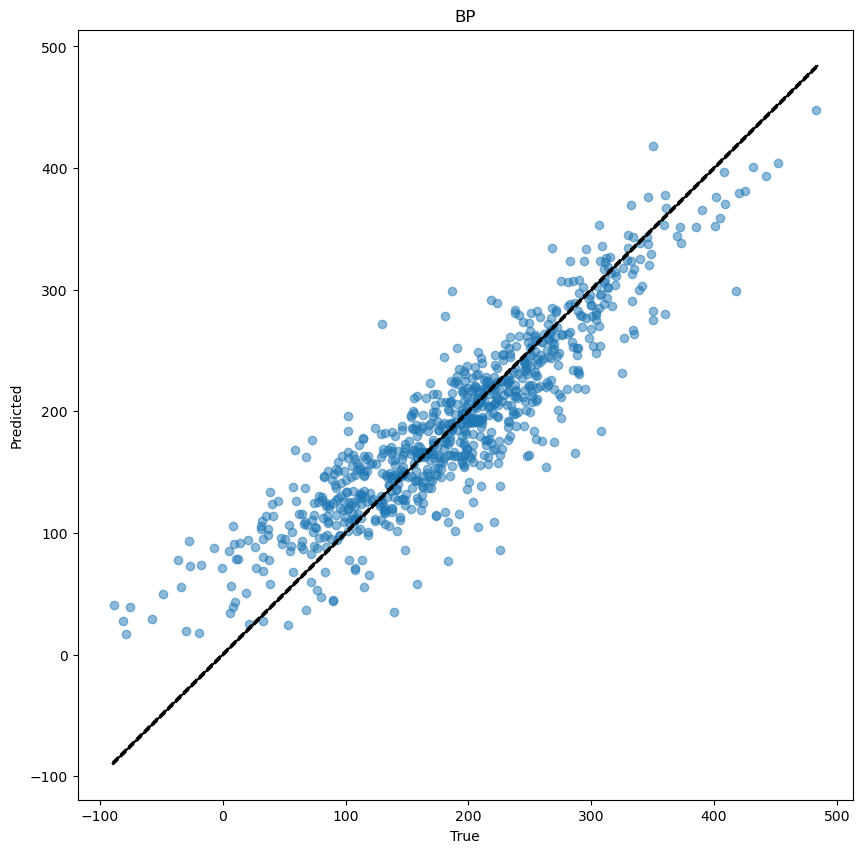

Property: LogHL
kendall_tau: 0.40068874392862835
rmse_overall: 1.560290101915394
mae_overall: 1.2595356391787889
within_03_overall: 0.16216216216216217
within_1_overall: 0.4594594594594595
R2: 0.47277334538474414
Pearson: 0.7142679175512204


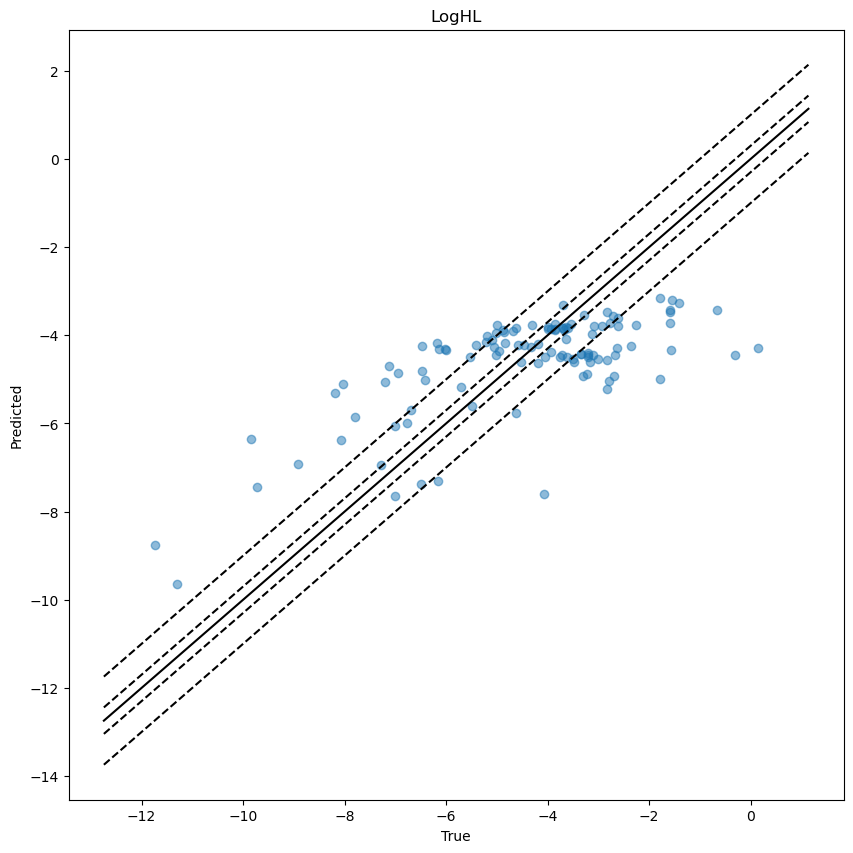

Property: LogKOA
kendall_tau: 0.8588235294117648
rmse_overall: 0.6148277261479702
mae_overall: 0.52131295260787
within_03_overall: 0.2571428571428571
within_1_overall: 0.9142857142857143
R2: 0.9608935386148805
Pearson: 0.9808717384903856


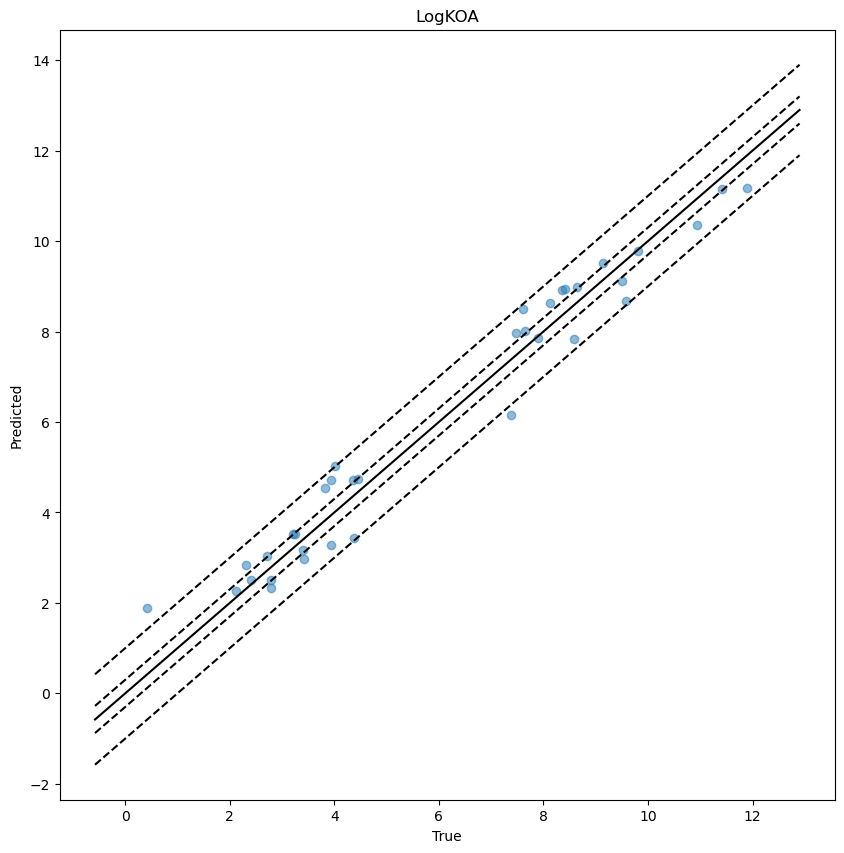

Property: MP
kendall_tau: 0.5840599387310231
rmse_overall: 63.43043784230142
mae_overall: 48.80564939570997
within_03_overall: 0.00361794500723589
within_1_overall: 0.012301013024602027
R2: 0.6021391704684318
Pearson: 0.7773408389008065


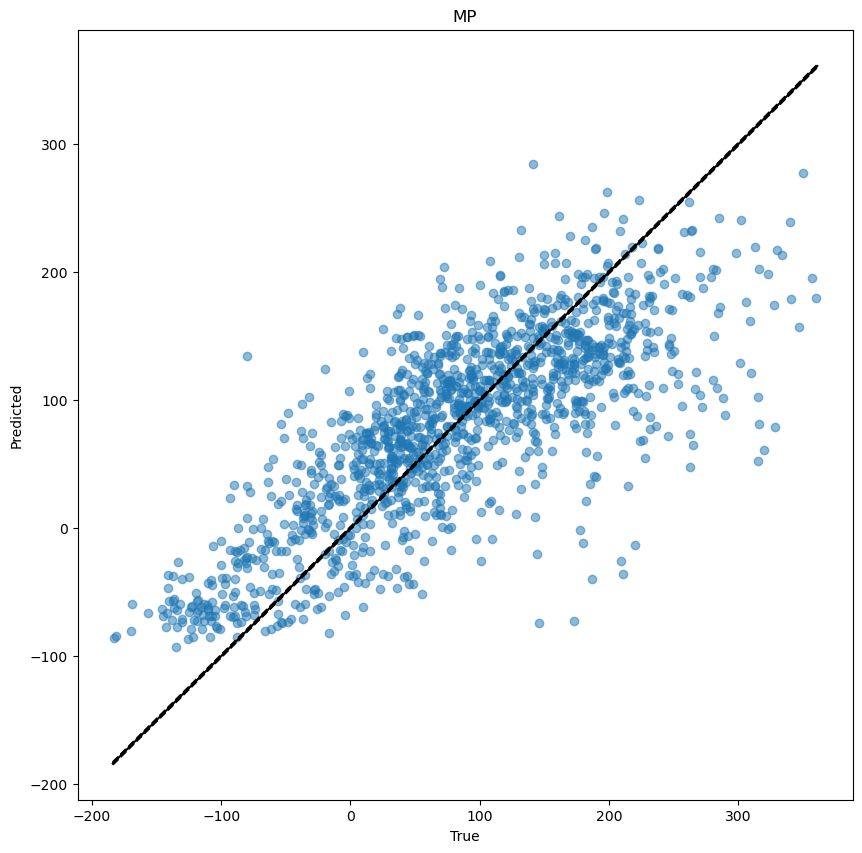

In [15]:
#test with some props that seem to be related at first glance: HL, KOA,LogP, MP,BP,VP
from utils_data import get_graphs
from sklearn.model_selection import train_test_split
from utils_plotting import plot_scatters
train = pd.read_csv('train.csv')

train_graphs_DASH_charge_scaled = get_graphs(train,dash_charges=True,scaled =True,save_graphs = True)
props = ['LogHL','LogKOA','LogP','MP','BP','LogVP']
outputs = 14 #keep this at 14 for now, this is all the properties for which graphs are made
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
name = "test_DASH_scaled_6props_new_scaling_test"
train_data, val_data = train_test_split(train_graphs_DASH_charge_scaled, test_size=0.2, random_state=2000)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
print(len(train_data), len(val_data))
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True,props_to_train=props,name=name)
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs, #note that using the DASH graphs will increase the amount of node feauters (input channels for model) from 23 to 24
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
model.load_state_dict(torch.load(name+'.pt'))
preds, ys = get_preds_per_task(model,val_loader, outputs,props_to_predict=props)
df_preds = vals_to_df(preds,props)
df_ys = vals_to_df(ys,props)
# print(print_rmse_and_r2_scaled(df_preds,df_ys))
print('-----------------------------------')
plot_scatters(df_preds,df_ys)
